In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
import os
import pandas as pd
import numpy as np 
import tensorflow as tf
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error, r2_score
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [6]:
pip install protobuf==3.20.3

   ---------------------------------------- 905.1/905.1 kB 5.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
print("SHAP version is:", shap.__version__)
print("Tensorflow version is:", tf.__version__)

SHAP version is: 0.42.1
Tensorflow version is: 1.14.0


In [4]:
def invTransform(scaler, data, colName, colNames):  
    dummy = pd.DataFrame(np.zeros((len(data), len(colNames))), columns=colNames)
    dummy[colName] = data
    dummy = pd.DataFrame(scaler.inverse_transform(dummy), columns=colNames)
    return dummy[colName].values

In [5]:
data_dir = './GHI_dataset/cleaned_sampled_data/'
file_path = os.path.join(data_dir, 'GHI_sampled_15_minutes.csv')
data_df = pd.read_csv(file_path, index_col=0)
print("Shape of the DataFrame:", data_df.shape)
print(data_df.head())
batch_size = min(64, int(data_df.shape[0]))

Shape of the DataFrame: (85620, 4)
                           GHI       GHIcs         k  year
datetime                                                  
2016-01-08 07:45:00  15.493833   30.867480  0.502025  2016
2016-01-08 08:00:00  19.661811   44.471446  0.445900  2016
2016-01-08 08:15:00  32.672067   72.424197  0.451816  2016
2016-01-08 08:30:00  25.506444  102.085192  0.253289  2016
2016-01-08 08:45:00  28.154833  131.848251  0.214493  2016


In [6]:
nPrevSteps = 5
polynomialAug = 5
basicFeatures = ['GHI', 'GHIcs', 'k']

In [7]:
nFeatures = len(basicFeatures)
X = data_df.loc[:, basicFeatures]
print("Array X", X.head())

Array X                            GHI       GHIcs         k
datetime                                            
2016-01-08 07:45:00  15.493833   30.867480  0.502025
2016-01-08 08:00:00  19.661811   44.471446  0.445900
2016-01-08 08:15:00  32.672067   72.424197  0.451816
2016-01-08 08:30:00  25.506444  102.085192  0.253289
2016-01-08 08:45:00  28.154833  131.848251  0.214493


In [8]:
poly = PolynomialFeatures(polynomialAug)
X_poly = poly.fit_transform(X)
colNames = poly.get_feature_names_out(X.columns)
print("Augmented Column Names", colNames)

Augmented Column Names ['1' 'GHI' 'GHIcs' 'k' 'GHI^2' 'GHI GHIcs' 'GHI k' 'GHIcs^2' 'GHIcs k'
 'k^2' 'GHI^3' 'GHI^2 GHIcs' 'GHI^2 k' 'GHI GHIcs^2' 'GHI GHIcs k'
 'GHI k^2' 'GHIcs^3' 'GHIcs^2 k' 'GHIcs k^2' 'k^3' 'GHI^4' 'GHI^3 GHIcs'
 'GHI^3 k' 'GHI^2 GHIcs^2' 'GHI^2 GHIcs k' 'GHI^2 k^2' 'GHI GHIcs^3'
 'GHI GHIcs^2 k' 'GHI GHIcs k^2' 'GHI k^3' 'GHIcs^4' 'GHIcs^3 k'
 'GHIcs^2 k^2' 'GHIcs k^3' 'k^4' 'GHI^5' 'GHI^4 GHIcs' 'GHI^4 k'
 'GHI^3 GHIcs^2' 'GHI^3 GHIcs k' 'GHI^3 k^2' 'GHI^2 GHIcs^3'
 'GHI^2 GHIcs^2 k' 'GHI^2 GHIcs k^2' 'GHI^2 k^3' 'GHI GHIcs^4'
 'GHI GHIcs^3 k' 'GHI GHIcs^2 k^2' 'GHI GHIcs k^3' 'GHI k^4' 'GHIcs^5'
 'GHIcs^4 k' 'GHIcs^3 k^2' 'GHIcs^2 k^3' 'GHIcs k^4' 'k^5']


In [9]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(X_poly)
scaled = scaler.transform(X_poly)
scaled = pd.DataFrame(scaled, columns = colNames, index = data_df.index)
scaled = scaled.drop("1", axis=1)
nFeatureColumns = scaled.shape[1]
print("Data Frame: ", scaled.head())
print("Data Frame Feature Columns: ", nFeatureColumns)

Data Frame:                            GHI     GHIcs         k     GHI^2  GHI GHIcs  \
datetime                                                                 
2016-01-08 07:45:00  0.013576  0.001012  0.019790  0.000239   0.000470   
2016-01-08 08:00:00  0.017782  0.017014  0.017551  0.000388   0.000930   
2016-01-08 08:15:00  0.030911  0.049893  0.017787  0.001078   0.002661   
2016-01-08 08:30:00  0.023680  0.084781  0.009868  0.000656   0.002937   
2016-01-08 08:45:00  0.026353  0.119790  0.008320  0.000800   0.004224   

                        GHI k   GHIcs^2   GHIcs k       k^2     GHI^3  ...  \
datetime                                                               ...   
2016-01-08 07:45:00  0.000316  0.000068  0.012874  0.000401  0.000004  ...   
2016-01-08 08:00:00  0.000357  0.001392  0.017029  0.000316  0.000008  ...   
2016-01-08 08:15:00  0.000601  0.005615  0.029389  0.000325  0.000036  ...   
2016-01-08 08:30:00  0.000263  0.012304  0.022807  0.000102  0.000017  ...   


In [10]:
train_test_df = pd.DataFrame()
for i in range(0, nPrevSteps+1, 1):
    title = scaled.columns + 't(-' + str(i) + ')'
    temp = scaled.shift(periods = i)
    temp.columns = title
    train_test_df = pd.concat([train_test_df, temp], axis=1)

print("Data Frame: ", train_test_df.head())
train_test_df = train_test_df.dropna()

Data Frame:                       GHIt(-0)  GHIcst(-0)    kt(-0)  GHI^2t(-0)  \
datetime                                                          
2016-01-08 07:45:00  0.013576    0.001012  0.019790    0.000239   
2016-01-08 08:00:00  0.017782    0.017014  0.017551    0.000388   
2016-01-08 08:15:00  0.030911    0.049893  0.017787    0.001078   
2016-01-08 08:30:00  0.023680    0.084781  0.009868    0.000656   
2016-01-08 08:45:00  0.026353    0.119790  0.008320    0.000800   

                     GHI GHIcst(-0)  GHI kt(-0)  GHIcs^2t(-0)  GHIcs kt(-0)  \
datetime                                                                      
2016-01-08 07:45:00        0.000470    0.000316      0.000068      0.012874   
2016-01-08 08:00:00        0.000930    0.000357      0.001392      0.017029   
2016-01-08 08:15:00        0.002661    0.000601      0.005615      0.029389   
2016-01-08 08:30:00        0.002937    0.000263      0.012304      0.022807   
2016-01-08 08:45:00        0.004224    0.00

In [11]:
title_0 = scaled.columns + 't(-' + str(0) + ')'
X = train_test_df.drop(title_0, axis = 1).values
y = train_test_df['GHIt(-0)'].values
print("Data Frame: ", X.shape)

Data Frame:  (85615, 275)


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_validation, X_test, y_validation, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=False)
X_train_r = X_train.reshape((X_train.shape[0], nPrevSteps, nFeatureColumns))
X_validation_r = X_validation.reshape((X_validation.shape[0], nPrevSteps, nFeatureColumns))
X_test_r = X_test.reshape((X_test.shape[0], nPrevSteps, nFeatureColumns))

print("Shapes (X_train_R, X_validation_r, X_test_R)", X_train_r.shape, X_validation_r.shape, X_test_r.shape)

Shapes (X_train_R, X_validation_r, X_test_R) (68492, 5, 55) (8561, 5, 55) (8562, 5, 55)


In [13]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X_train_r.shape[1], X_train_r.shape[2])))
model.add(LSTM(64, return_sequences=True, input_shape=(X_train_r.shape[1], X_train_r.shape[2]))) 
model.add(LSTM(64, return_sequences=False, input_shape=(X_train_r.shape[1], X_train_r.shape[2])))
model.add(Dense(1))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [14]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose = 0, patience=10, restore_best_weights=True)
model.compile(loss='mse', optimizer='adam')
history = model.fit(X_train_r, y_train, epochs=5, validation_split=0.2, batch_size=32, callbacks=[es], verbose=1, shuffle = False)

Train on 54793 samples, validate on 13699 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/5
54793/54793 [==============================] - 48s 876us/sample - loss: 0.0062 - val_loss: 0.0052
Epoch 2/5
54793/54793 [==============================] - 49s 895us/sample - loss: 0.0051 - val_loss: 0.0047
Epoch 3/5
54793/54793 [==============================] - 51s 930us/sample - loss: 0.0047 - val_loss: 0.0046
Epoch 4/5
54793/54793 [==============================] - 53s 969us/sample - loss: 0.0046 - val_loss: 0.0046
Epoch 5/5
54793/54793 [==============================] - 53s 961us/sample - loss: 0.0045 - val_loss: 0.0046


In [15]:
y_pred = model.predict(X_test_r)

print("Shape of Y_Pred: ", y_pred.shape)
print("Shape of Y_Test: ", y_test.shape)

y_pred_inv = invTransform(scaler, y_pred, 'GHI', colNames)
y_test_inv = invTransform(scaler, y_test, 'GHI', colNames)

print("Shape of Y_Pred_inv: ", y_pred.shape)
print("Shape of Y_test_inv: ", y_test.shape)

Shape of Y_Pred:  (8562, 1)
Shape of Y_Test:  (8562,)
Shape of Y_Pred_inv:  (8562, 1)
Shape of Y_test_inv:  (8562,)


In [16]:
mse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
nrmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv)) / np.mean(y_test_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
nmae = mean_absolute_error(y_test_inv, y_pred_inv) / np.mean(y_test_inv) 
r2 = r2_score(y_test_inv, y_pred_inv)

print(f'RMSE: {mse}, nRMSE: {nrmse}, MAE: {mae}, nMAE: {nmae}, R2: {r2}')

RMSE: 73.56546137812859, nRMSE: 0.19968816870385636, MAE: 48.02602745395346, nMAE: 0.13036320703688706, R2: 0.9194018454148782


In [17]:
sample_size = 100
subset_size = 100
colNames = colNames[1:]
random_indices = np.random.choice(X_train_r.shape[0], size=sample_size, replace=False)
X_train_sample = X_train_r[random_indices]

indices = np.random.choice(X_test_r.shape[0], subset_size, replace=False)
X_test_r_subset = X_test_r[indices]

print("Shapes: ", X_train_sample.shape, X_test_r_subset.shape)

Shapes:  (100, 5, 55) (100, 5, 55)


In [18]:
explainer = shap.DeepExplainer(model, X_train_sample)
shap_values_subset = explainer.shap_values(X_test_r_subset)

In [19]:
print(explainer.expected_value[0])
print(np.asarray(shap_values_subset[0][0]).shape)
print(np.asarray(X_test_r_subset[0]).shape)
print(len(colNames))
assert len(colNames) == 55

0.31203765
(5, 55)
(5, 55)
55


In [20]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values_subset[0][0][0], colNames)

In [21]:
print(np.asarray(shap_values_subset).shape)
print(np.asarray(X_test_r_subset).shape)

(1, 100, 5, 55)
(100, 5, 55)


In [22]:
shap_values_to_plot = np.squeeze(shap_values_subset)
feature_names_expanded = [f"{name}_t{t+1}" for t in range(X_test_r_subset.shape[1]) for name in colNames]
#print(feature_names_expanded)
print(np.asarray(feature_names_expanded).shape)
#print(shap_values_to_plot)

(275,)


In [23]:
shap_values_to_plot = np.squeeze(shap_values_subset)
n_samples = X_test_r_subset.shape[0]
shap_values_flattened = shap_values_to_plot.reshape(n_samples, -1)
X_test_r_flattened = X_test_r_subset.reshape(n_samples, -1)

print("Shape of shap_values_flattened:", shap_values_flattened.shape)
print("Shape of X_test_r_flattened:", X_test_r_flattened.shape)

Shape of shap_values_flattened: (100, 275)
Shape of X_test_r_flattened: (100, 275)


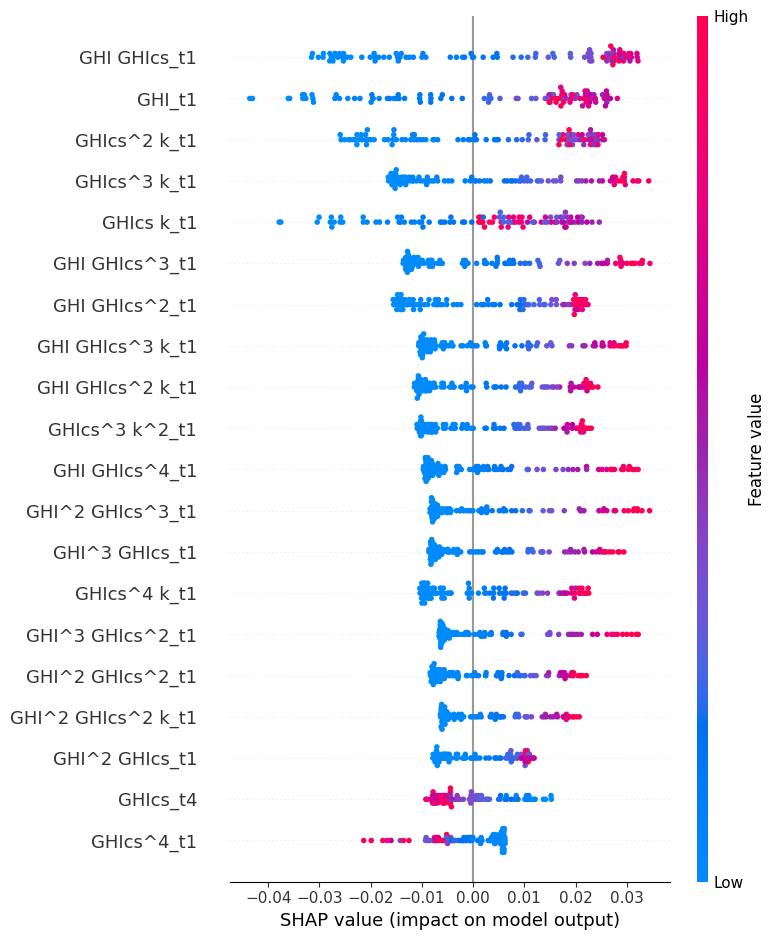

In [24]:
shap.summary_plot(shap_values_flattened, X_test_r_flattened, feature_names_expanded)

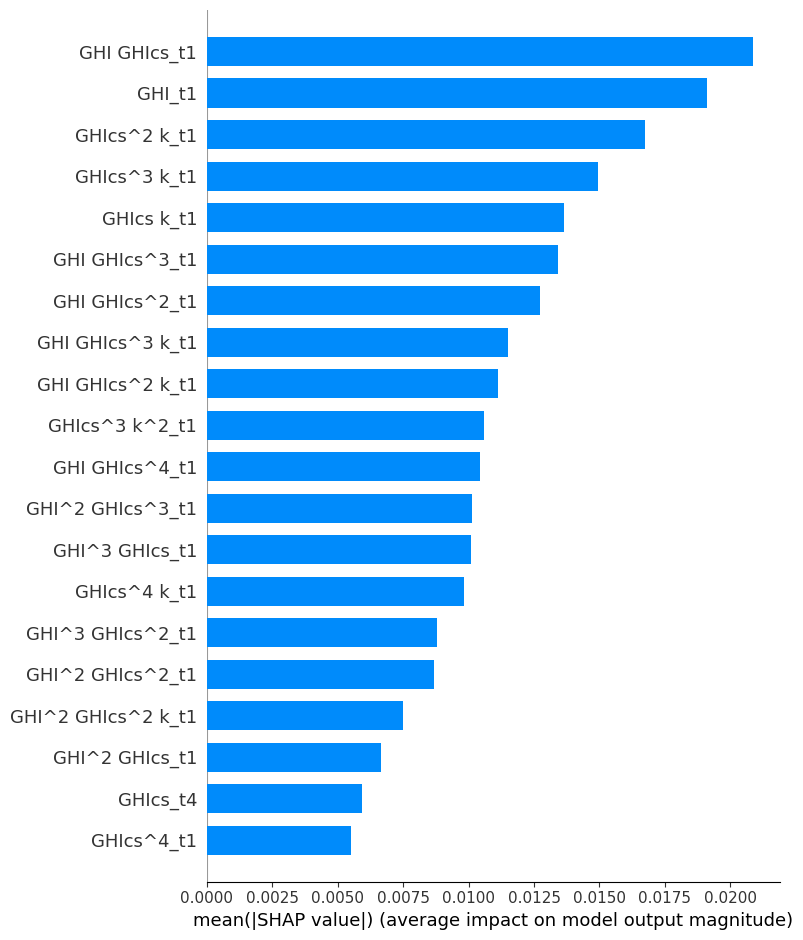

In [25]:
shap.summary_plot(shap_values_flattened, X_test_r_flattened, plot_type="bar", feature_names = feature_names_expanded)